
--- Iniciando Simulación: dinamarca_BA_m1_CM95pNODK_H0p ---
Creando red tipo 'Barabási-Albert'...
Calculando centralidad...
  Usando centralidad de Eigenvector.
Seleccionando 950 nodos CM (Nodos centrales)...
Inicializando estrategias...
Iniciando 100 rondas...
Simulación completada.
  Gráfica de evolución guardada en: Resultados_Simulacion_Animada\dinamarca_BA_m1_CM95pNODK_H0p
  Calculando layout para visualizaciones...
  Gráfica de red final guardada en: Resultados_Simulacion_Animada\dinamarca_BA_m1_CM95pNODK_H0p
  Iniciando generación de animación GIF (puede tardar)...
  Animación guardada como 'Resultados_Simulacion_Animada\dinamarca_BA_m1_CM95pNODK_H0p\dinamarca_BA_m1_CM95pNODK_H0p_animacion.gif' en 458.88 seg.

--- Iniciando Simulación: dinamarca_BA_m1_CM95pNODK_H0p ---
Creando red tipo 'Barabási-Albert'...
Calculando centralidad...
  Usando centralidad de Eigenvector.
Seleccionando 950 nodos CM (Nodos aleatorios)...
Inicializando estrategias...
Iniciando 100 rondas...
Simulació

KeyboardInterrupt: 

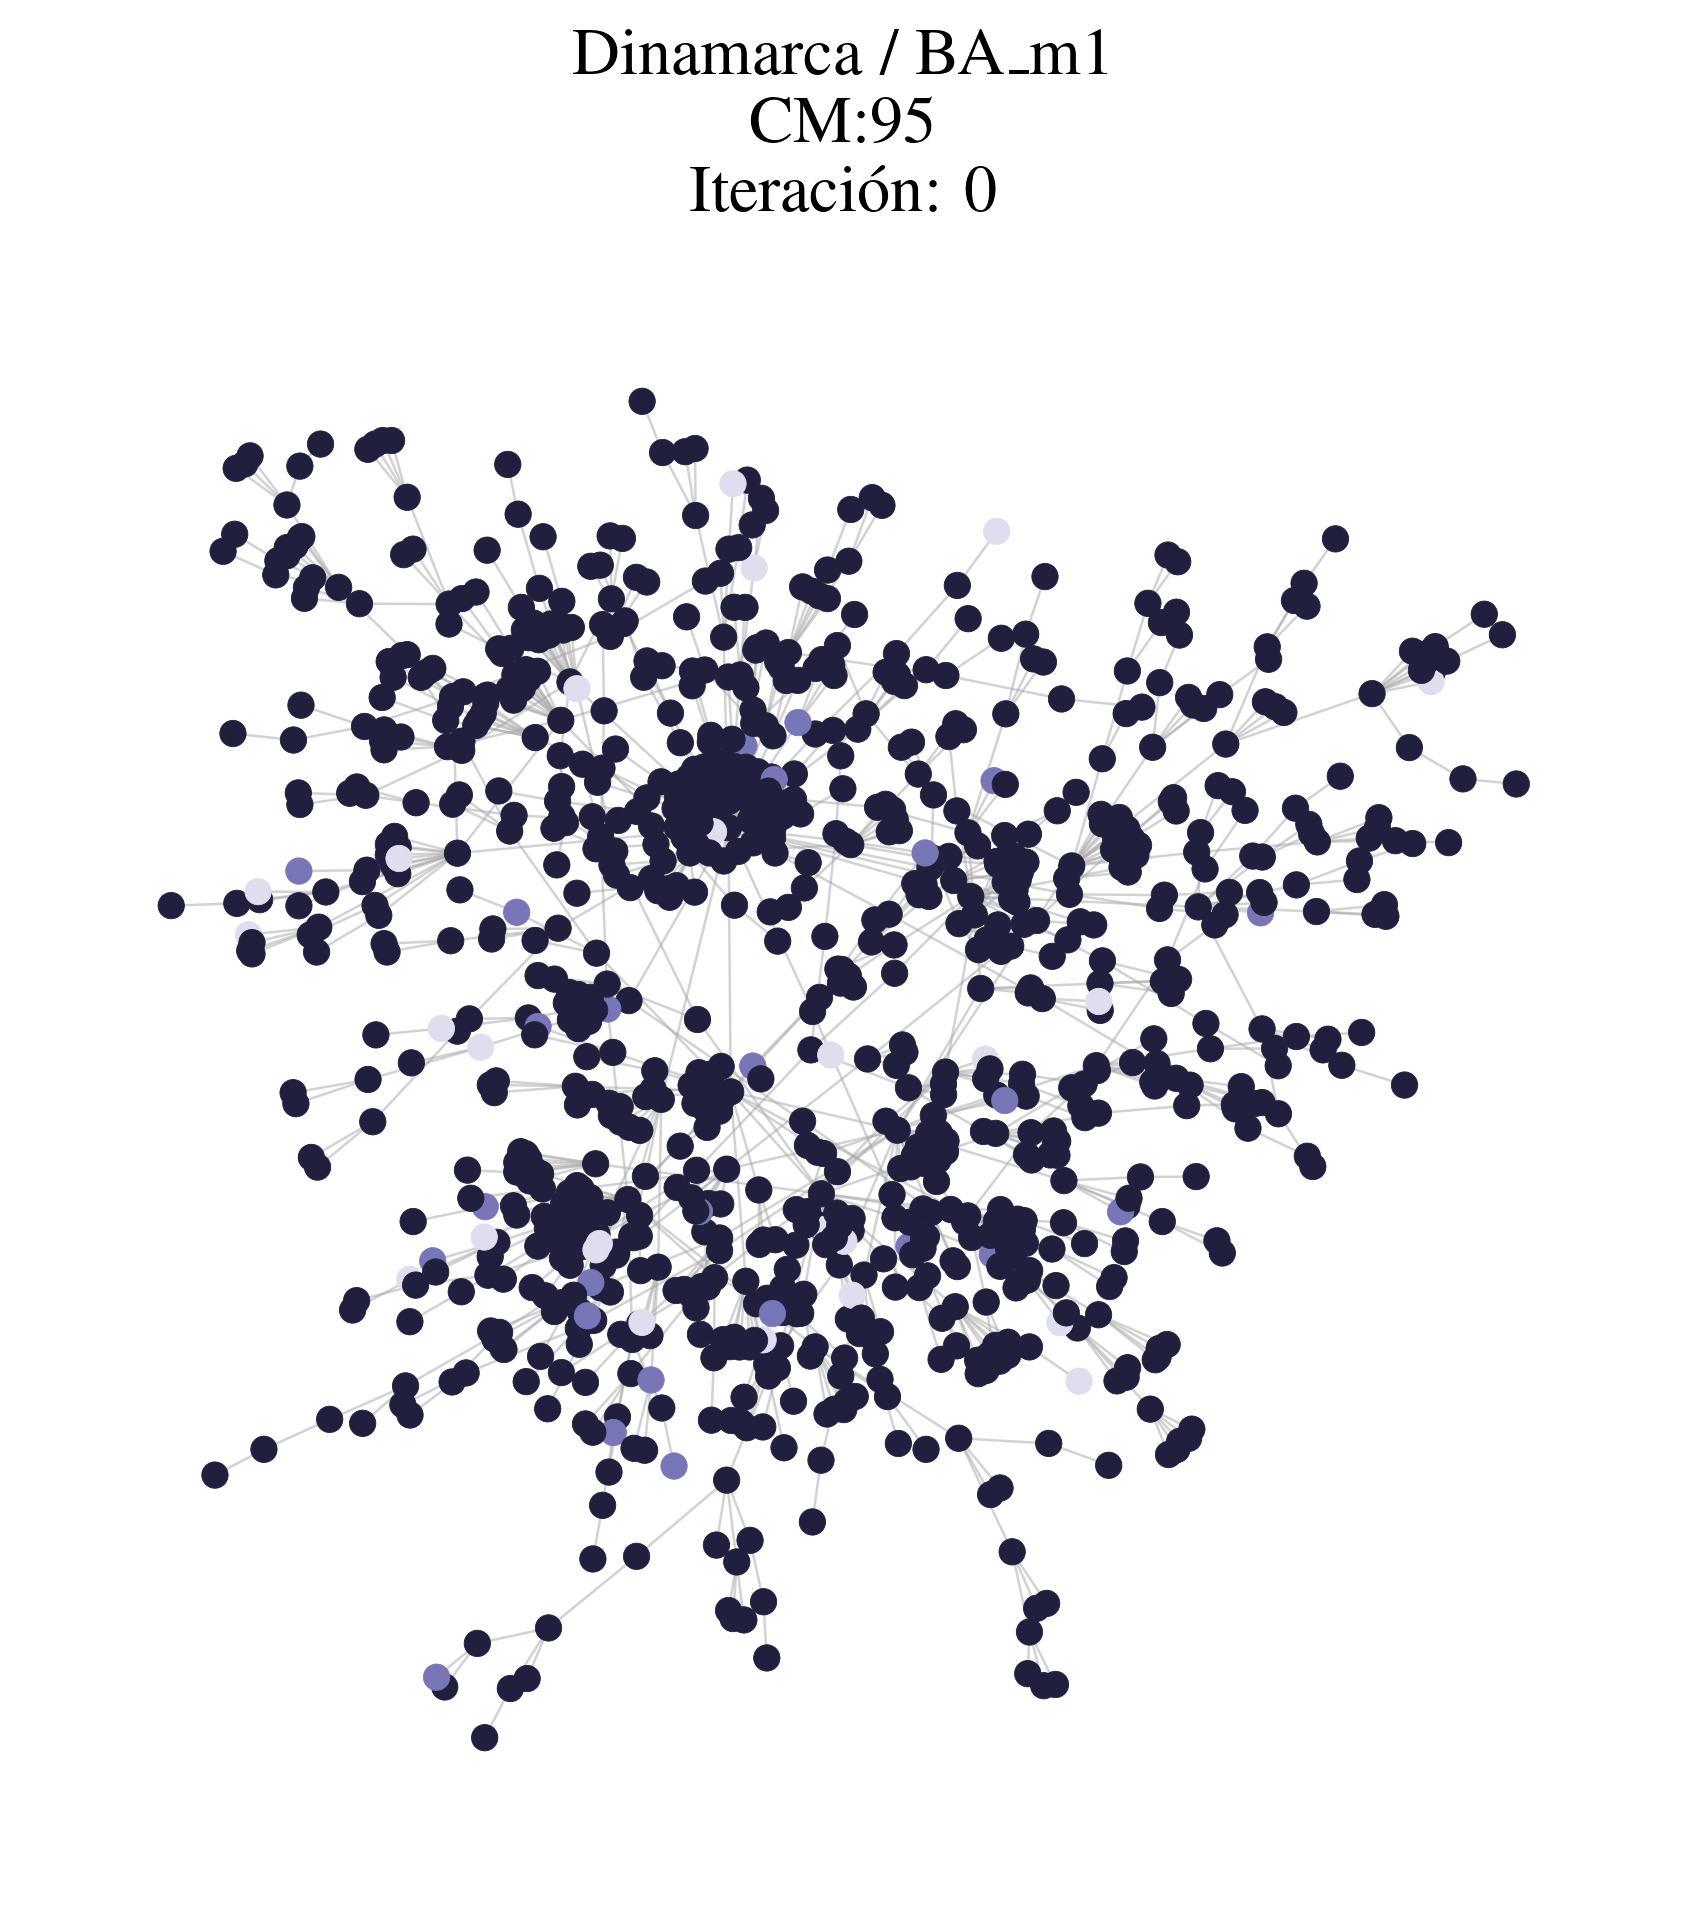

In [ ]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scienceplots
from networkx.algorithms import community
import os
import time
import sys
import re
from matplotlib.animation import FuncAnimation # <-- Importar para animación
from collections import Counter

try:
    from IPython.display import SVG, display, Image
except ImportError:
    SVG, display, Image = None, None, None

# --- Parámetros Juego y Funciones de Simulación (Minimizadas para claridad, con un cambio clave) ---
PARAMS_DINAMARCA = {'r': 2.5, 's': 1, 't': 3, 'p': 8, 'c': 0.2, 'q': 11, 'd': 0.5}
PARAMS_SINGAPUR =  {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 15, 'd': 0.2}
PARAMS_MEXICO =    {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 2, 'q': 5, 'd': 4}

def calcular_pago_individual_corrupcion(strat_i, strat_j, params): # ... (igual) ...
    r, s, t, p, c, q, d = params['r'], params['s'], params['t'], params['p'], params['c'], params['q'], params['d']
    payoffs = { ('C', 'C'): r, ('C', 'D'): -s, ('C', 'H'): r, ('C', 'K'): -s, ('D', 'C'): t, ('D', 'D'): 0, ('D', 'H'): t-p, ('D', 'K'): -p, ('H', 'C'): r, ('H', 'D'): -s-c, ('H', 'H'): r, ('H', 'K'): -s-d, ('K', 'C'): t, ('K', 'D'): -c, ('K', 'H'): t-q, ('K', 'K'): -q-d }
    return payoffs.get((strat_i, strat_j), 0)

def actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength): # ... (igual) ...
    estrategia_actual = estrategias[nodo]; recompensa_total_actual = recompensas_totales[nodo]
    vecinos = list(red.neighbors(nodo))
    if not vecinos: return estrategia_actual
    vecino_elegido = random.choice(vecinos); estrategia_vecino = estrategias[vecino_elegido]; recompensa_total_vecino = recompensas_totales[vecino_elegido]
    probabilidad_adoptar_base = 0.0
    try:
        if K <= 1e-9: probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
        else: delta_recompensa_scaled = np.clip((recompensa_total_actual - recompensa_total_vecino) / K, -700, 700); probabilidad_adoptar_base = 1 / (1 + np.exp(delta_recompensa_scaled))
    except (OverflowError, FloatingPointError): probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
    if estrategia_actual == estrategia_vecino: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 + homophily_strength)
    else: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 - homophily_strength)
    probabilidad_adoptar_final = np.clip(probabilidad_adoptar_final, 0.0, 1.0)
    return estrategia_vecino if random.random() < probabilidad_adoptar_final else estrategia_actual

def calcular_centralidad(red): # ... (igual) ...
    try: centrality = nx.eigenvector_centrality_numpy(red); print("  Usando centralidad de Eigenvector.")
    except Exception as e: print(f"  Advertencia: Eigenvector falló ({e}). Usando Grado."); centrality = nx.degree_centrality(red)
    return centrality

def seleccionar_nodos_cm(centrality_dict, cm_size, placement_type): # ... (igual) ...
    cm_size = int(round(cm_size))
    if not 0 <= cm_size <= len(centrality_dict): raise ValueError(f"CM size ({cm_size}) inválido.")
    if cm_size == 0: return []
    if cm_size == len(centrality_dict): return list(centrality_dict.keys())
    reverse_sort = (placement_type == 'Nodos centrales')
    nodos_ordenados = sorted(centrality_dict, key=centrality_dict.get, reverse=reverse_sort)
    if placement_type in ['Nodos centrales', 'Nodos perifericos']: cm_nodes = nodos_ordenados[:cm_size]
    elif placement_type == 'Nodos aleatorios': cm_nodes = random.sample(list(centrality_dict.keys()), cm_size)
    else: raise ValueError(f"Colocación CM desconocida: {placement_type}")
    return cm_nodes

def inicializar_estrategias_cm_flexible(n, cm_nodes, cm_strategies, non_cm_strategies, seed=None): # ... (igual) ...
    if seed is not None: random.seed(seed)
    estrategias = {}; non_cm_nodes = list(set(range(n)) - set(cm_nodes))
    if not cm_strategies and cm_nodes : raise ValueError("cm_strategies vacía pero cm_nodes no lo está.")
    if not non_cm_strategies and non_cm_nodes: raise ValueError("non_cm_strategies vacía pero non_cm_nodes no lo está.")
    random.shuffle(cm_nodes); random.shuffle(non_cm_nodes)
    if cm_strategies:
        for i, nodo in enumerate(cm_nodes): estrategias[nodo] = cm_strategies[i % len(cm_strategies)]
    if non_cm_strategies:
        for i, nodo in enumerate(non_cm_nodes): estrategias[nodo] = non_cm_strategies[i % len(non_cm_strategies)]
    return dict(sorted(estrategias.items()))

def ejecutar_simulacion_corrupcion(num_nodos=100, network_type='Completa', network_params=None, cm_size_actual=50, cm_placement_type='Nodos aleatorios', cm_strategies = ['C', 'H'], non_cm_strategies = ['D', 'K'], params_juego=PARAMS_MEXICO, K=0.1, homophily_strength=0.0, rondas=15, seed=None):
    if seed is not None: random.seed(seed); np.random.seed(seed)
    print(f"Creando red tipo '{network_type}'..."); network_params_str_out = ""
    if network_type == 'Completa': red = nx.complete_graph(num_nodos)
    elif network_type == 'Barabási-Albert':
        if network_params is None: network_params = {}
        m = network_params.get('m', 2)
        if m >= num_nodos: m = max(1, num_nodos // 2)
        red = nx.barabasi_albert_graph(num_nodos, m, seed=seed); network_params_str_out = f" m={m}"
    else: raise ValueError(f"Tipo de red desconocido: {network_type}")
    print(f"Calculando centralidad..."); centrality = calcular_centralidad(red)
    print(f"Seleccionando {cm_size_actual} nodos CM ({cm_placement_type})..."); cm_nodes = seleccionar_nodos_cm(centrality, cm_size_actual, cm_placement_type)
    print(f"Inicializando estrategias..."); estrategias = inicializar_estrategias_cm_flexible(num_nodos, cm_nodes, cm_strategies, non_cm_strategies, seed=seed)
    # --- CAMBIO CLAVE: GUARDAR HISTORIAL COMPLETO DE ESTRATEGIAS ---
    historial_estrategias_completo = [estrategias.copy()]
    # ------------------------------------------------------------------
    historia_fracciones = {'C': [], 'D': [], 'H': [], 'K': []}; nodos_lista = list(red.nodes())
    conteo_inicial = Counter(estrategias.values());
    for strat_key in ['C', 'D', 'H', 'K']: historia_fracciones[strat_key].append(conteo_inicial.get(strat_key, 0) / num_nodos if num_nodos > 0 else 0)
    print(f"Iniciando {rondas} rondas...");
    for r in range(rondas):
        recompensas_totales = {nodo: 0 for nodo in nodos_lista}
        for nodo_i in nodos_lista:
            strat_i = estrategias[nodo_i]; vecinos_i = list(red.neighbors(nodo_i))
            if not vecinos_i: continue
            for nodo_j in vecinos_i: strat_j = estrategias[nodo_j]; recompensas_totales[nodo_i] += calcular_pago_individual_corrupcion(strat_i, strat_j, params_juego)
        siguientes_estrategias = {}; nodos_actualizar = nodos_lista[:]; random.shuffle(nodos_actualizar)
        for nodo in nodos_actualizar: siguientes_estrategias[nodo] = actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength)
        estrategias = siguientes_estrategias
        # --- CAMBIO CLAVE: GUARDAR HISTORIAL COMPLETO DE ESTRATEGIAS ---
        historial_estrategias_completo.append(estrategias.copy())
        # ------------------------------------------------------------------
        conteo_actual = Counter(estrategias.values())
        for strat_key in ['C', 'D', 'H', 'K']: fraccion = conteo_actual.get(strat_key, 0) / num_nodos if num_nodos > 0 else 0; historia_fracciones[strat_key].append(fraccion)
    print("Simulación completada.")
    # Devolver también el historial completo
    return historia_fracciones, red, estrategias, historial_estrategias_completo

# --- Funciones de Graficado y Análisis (Minimizadas, sin cambios) ---
class Logger: #... (igual)
    def __init__(self, filename="log.txt"): self.terminal = sys.stdout; self.log = open(filename, "w", encoding='utf-8')
    def write(self, message): self.terminal.write(message); self.log.write(message)
    def flush(self): self.terminal.flush(); self.log.flush()
    def close(self): self.log.close()
def analizar_mostrarRed(G, output_path): # ... (igual)
    plt.style.use('science'); plt.figure(figsize=(3, 3));
    try: pos = nx.spring_layout(G, seed=42, k=0.6/np.sqrt(G.number_of_nodes()) if G.number_of_nodes()>0 else 0.1)
    except: pos = nx.circular_layout(G)
    nx.draw(G, pos, node_size=30, node_color='#9FA3D5', edge_color='#3B4285', width=0.5, with_labels=False)
    plt.title('Visualización Subred Corrupta (K)'); plt.savefig(f"{output_path}_visualizacion.png", dpi=300, bbox_inches='tight'); plt.close()
def analizar_distribucionDeGrado(G, output_path): # ... (igual)
    if not G.nodes() or not G.edges(): print("  - Distribución Grado: Subred sin nodos/aristas."); return
    degrees = [d for n, d in G.degree()]; unique_degrees, counts = np.unique(degrees, return_counts=True); probs = counts / len(G)
    non_zero_probs = probs[probs > 0]; non_zero_degrees = unique_degrees[probs > 0]; valid_log = non_zero_degrees > 0; gamma = np.nan
    if np.any(valid_log) and len(non_zero_degrees[valid_log]) > 1:
        log_probs = np.log(non_zero_probs[valid_log]); log_degrees = np.log(non_zero_degrees[valid_log])
        slope, intercept, _, _, _ = linregress(log_degrees, log_probs); gamma = round(slope, 2)
        plt.style.use('science'); plt.figure(figsize=(3, 3)); plt.loglog(non_zero_degrees, non_zero_probs, 'o', color='#9FA3D5', markersize=3)
        plt.plot(non_zero_degrees[valid_log], np.exp(intercept + slope * np.log(non_zero_degrees[valid_log])), '--', label=f'Ajuste (γ={gamma})', color='#3B4285', linewidth=1)
        plt.xlabel('Grado (k) - Escala Log'); plt.ylabel('P(k) - Escala Log'); plt.legend(fontsize='small'); plt.savefig(f"{output_path}_dist_grado_log.png", dpi=300, bbox_inches='tight'); plt.close()
    else: print("  - Distribución Grado: No hay suficientes puntos para ajuste.")
    print(f"  - Exponente ley de potencias (gamma): {gamma}")
def analizar_estructuraComunidades(G): # ... (igual)
    if not G.nodes() or not G.edges(): print("  - Comunidades: Subred sin nodos/aristas."); return G.copy()
    try: comunidades = list(community.louvain_communities(G, seed=42))
    except: print("  - Comunidades: Error en algoritmo Louvain."); return G.copy()
    num_comunidades = len(comunidades); nodos_comunidad = [len(c) for c in comunidades]; promedio_nodos = round(np.mean(nodos_comunidad), 2) if nodos_comunidad else 0
    print(f"  - Número de comunidades: {num_comunidades}"); print(f"  - Promedio de nodos por comunidad: {promedio_nodos}")
    if num_comunidades > 0:
        max_comunidad_size = max(nodos_comunidad); print(f"  - Comunidad más grande: {max_comunidad_size} nodos")
        return G.subgraph(comunidades[np.argmax(nodos_comunidad)]).copy()
    return G.copy()
def analizar_mundoPequeno(G, G_max_comunidad): # ... (igual)
    if not G.nodes(): print("  - Mundo Pequeño: Subred vacía."); return
    clustering_coeff = round(nx.average_clustering(G), 3); avg_path_len = np.nan
    if G_max_comunidad.nodes() and nx.is_connected(G_max_comunidad): avg_path_len = round(nx.average_shortest_path_length(G_max_comunidad), 3)
    print(f"  - Coeficiente de agrupamiento global: {clustering_coeff}"); print(f"  - Camino medio más corto (comp. gigante): {avg_path_len}")
def analizar_asortatividad(G, G_max_comunidad): # ... (igual)
    if not G.edges(): print("  - Asortatividad: Subred sin aristas."); return
    assort_global = round(nx.degree_assortativity_coefficient(G), 3); assort_local = np.nan
    if G_max_comunidad.edges(): assort_local = round(nx.degree_assortativity_coefficient(G_max_comunidad), 3)
    print(f"  - Asortatividad global: {assort_global}"); print(f"  - Asortatividad local (comp. gigante): {assort_local}")
def analizar_densidad(G, G_max_comunidad): # ... (igual)
    if not G.nodes(): print("  - Densidad: Subred vacía."); return
    density_global = round(nx.density(G), 4); density_local = np.nan
    if G_max_comunidad.nodes(): density_local = round(nx.density(G_max_comunidad), 4)
    print(f"  - Densidad global: {density_global}"); print(f"  - Densidad local (comp. gigante): {density_local}")
def analizar_subred_k_metricas(subgrafo_k, output_path_base): # ... (igual)
    if not isinstance(subgrafo_k, nx.Graph) or not subgrafo_k.nodes(): print("  Análisis de métricas omitido: Subred K vacía."); return
    os.makedirs(os.path.dirname(output_path_base), exist_ok=True)
    log_file = Logger(f"{output_path_base}_metricas.txt"); original_stdout = sys.stdout; sys.stdout = log_file
    print(f"--- ANÁLISIS DE SUBRED K: {os.path.basename(output_path_base)} ---"); print(f"Nodos: {subgrafo_k.number_of_nodes()}, Enlaces: {subgrafo_k.number_of_edges()}"); print("-" * 20)
    G_max_comunidad = analizar_estructuraComunidades(subgrafo_k); print("-" * 20)
    analizar_distribucionDeGrado(subgrafo_k, output_path_base); print("-" * 20)
    analizar_mundoPequeno(subgrafo_k, G_max_comunidad); analizar_asortatividad(subgrafo_k, G_max_comunidad); analizar_densidad(subgrafo_k, G_max_comunidad)
    print("-" * 20); print("--- FIN DE ANÁLISIS ---"); sys.stdout = original_stdout; log_file.close(); print(f"  Análisis de métricas de subred K guardado en: {log_file.log.name}")
    analizar_mostrarRed(subgrafo_k, output_path_base)
def graficar_evolucion(historia, titulo, output_path): # ... (igual)
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(2.5, 2.5))
    colores = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D'}
    estilos = {'C': '-', 'D': '--', 'H': ':', 'K': '-.'}; nombres_legenda = {'C': 'C. Coop', 'D': 'C. no Coop', 'H': 'P. Honrado', 'K': 'P. Corrupto'}
    rondas_totales = len(historia['C']); eje_x = range(rondas_totales)
    for strat in ['C', 'D', 'H', 'K']: plt.plot(eje_x, historia[strat], label=nombres_legenda[strat], color=colores[strat], linestyle=estilos[strat], linewidth=1)
    plt.xlabel("Iteraciones"); plt.ylabel("Porcentaje"); plt.title(titulo); plt.ylim(0, 1.0); plt.xlim(0, rondas_totales - 1 if rondas_totales > 1 else 1); plt.legend(fontsize=7, loc='best'); plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f"{output_path}_evolucion.svg", dpi=300, bbox_inches='tight'); plt.close()
def graficar_red_completa(red, estrategias, pos, titulo, output_path): # ... (igual)
    if not isinstance(red, nx.Graph) or not red.nodes(): return
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(3, 3)); n = red.number_of_nodes()
    color_map = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D', 'Unknown': '#808080'}
    node_colors = [color_map.get(estrategias.get(n, 'Unknown'), '#808080') for n in red.nodes()]
    node_size = 10 if n > 200 else 15; edge_alpha = 0.03 if n > 100 else 0.5; edge_width = 0.05 if n > 100 else 0.3
    nx.draw(red, pos, node_size=node_size, node_color=node_colors, edge_color="#A7A7A7", alpha=0.8, width=edge_width, with_labels=False)
    plt.title(titulo); plt.axis('off'); plt.savefig(f"{output_path}_red_final.png", dpi=150, bbox_inches='tight'); plt.close()

# ---------------------------------------------------------------------------
# --- NUEVA FUNCIÓN PARA GENERAR ANIMACIÓN ---
# ---------------------------------------------------------------------------
def animar_evolucion_red(historial_estrategias, red, pos, titulo, output_path_gif):
    """Genera y guarda una animación GIF de la evolución de las estrategias en la red."""
    print("  Iniciando generación de animación GIF (puede tardar)...")
    start_time = time.time()
    
    # Preparar figura y colores
    plt.style.use(['science', 'ieee'])
    fig_anim, ax_anim = plt.subplots(figsize=(3.5, 3.5))
    color_map = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D'}
    
    # Función que se llama para cada frame
    def update_frame(frame_number):
        ax_anim.clear()
        # Obtener las estrategias para este frame
        status_for_this_frame = historial_estrategias[frame_number]
        current_colors = [color_map.get(status_for_this_frame.get(node, 'C'), '#808080') for node in red.nodes()]
        
        # Dibujar la red
        nx.draw_networkx_nodes(red, pos, node_color=current_colors, node_size=10, linewidths=0.1, ax=ax_anim)
        nx.draw_networkx_edges(red, pos, edge_color="#A7A7A7", alpha=0.5, width=0.3, ax=ax_anim)
        
        ax_anim.set_title(f"{titulo}\nIteración: {frame_number}", fontsize=8)
        ax_anim.axis('off')

    num_frames = len(historial_estrategias)
    # Crear animación
    anim = FuncAnimation(fig_anim, update_frame, frames=num_frames, interval=150) # interval en ms
    
    # Guardar animación (requiere 'pillow' instalado: pip install pillow)
    try:
        anim.save(output_path_gif, writer='pillow', fps=10) # fps = frames por segundo
        print(f"  Animación guardada como '{output_path_gif}' en {time.time() - start_time:.2f} seg.")
    except Exception as e:
        print(f"  ERROR al guardar la animación: {e}")
        print("  Asegúrate de tener 'pillow' instalado (`pip install pillow`).")

    plt.close(fig_anim)


# --- Función Principal Modificada ---
def simular_y_analizar(
    nombre_pais, params_juego, num_nodos,
    network_type, network_params,
    cm_percentage, cm_placement_type,
    cm_strategies, non_cm_strategies,
    K, homophily_strength, rondas, seed,
    output_dir_base,
    flags
    ):
    # 1. Crear nombre de directorio y archivo descriptivo y sanitizado
    net_label = f"BA_m{network_params['m']}" if network_type == 'Barabási-Albert' else 'Comp'
    cm_place_label = cm_placement_type[:3].upper()
    cm_strat_label = "".join(sorted(cm_strategies))
    sanitized_pais = re.sub(r'[^\w-]', '', nombre_pais.lower())
    run_name = f"{sanitized_pais}_{net_label}_CM{cm_percentage}p{cm_place_label}{cm_strat_label}_H{int(homophily_strength*100)}p"
    output_dir_run = os.path.join(output_dir_base, run_name)
    os.makedirs(output_dir_run, exist_ok=True)
    output_path_base = os.path.join(output_dir_run, run_name)

    # 2. Ejecutar Simulación (ahora devuelve historial de estrategias)
    print(f"\n--- Iniciando Simulación: {run_name} ---")
    cm_size_actual = int(round((cm_percentage / 100) * num_nodos))
    historia_fracciones, red_final, estrategias_finales, historial_estrategias_completo = ejecutar_simulacion_corrupcion(
        num_nodos=num_nodos, network_type=network_type, network_params=network_params, cm_size_actual=cm_size_actual, cm_placement_type=cm_placement_type,
        cm_strategies=cm_strategies, non_cm_strategies=non_cm_strategies, params_juego=params_juego, K=K, homophily_strength=homophily_strength,
        rondas=rondas, seed=seed
    )

    # 3. Graficar Evolución
    titulo_evol = f"Evol: {nombre_pais} / {net_label}\nCM:{cm_percentage}% {cm_place_label}({cm_strat_label}) / H:{homophily_strength*100}%"
    graficar_evolucion(historia_fracciones, titulo_evol, output_path_base)
    print(f"  Gráfica de evolución guardada en: {output_dir_run}")

    # 4. Procesar Red Final
    pos = None
    if flags['graficar_redes'] or flags['generar_animacion']:
        print("  Calculando layout para visualizaciones...")
        try: pos = nx.spring_layout(red_final, seed=seed, k=0.6/np.sqrt(num_nodos) if num_nodos>0 else 0.1, iterations=30)
        except: pos = nx.circular_layout(red_final)

    if flags['graficar_redes'] and pos is not None:
        titulo_red = f"Red Final: {nombre_pais} / {net_label}\nCM:{cm_percentage}% {cm_place_label}({cm_strat_label}) / H:{homophily_strength*100}%"
        graficar_red_completa(red_final, estrategias_finales, pos, titulo_red, output_path_base)
        print(f"  Gráfica de red final guardada en: {output_dir_run}")

    # 5. Generar Animación
    if flags['generar_animacion'] and pos is not None:
        path_animacion = f"{output_path_base}_animacion.gif"
        titulo_anim = f"{nombre_pais} / {net_label}\nCM:{cm_percentage}%{cm_place_label}({cm_strat_label}) / H:{homophily_strength*100}%"
        animar_evolucion_red(historial_estrategias_completo, red_final, pos, titulo_anim, path_animacion)

    # 6. Analizar Subred K
    nodos_k = [n for n, s in estrategias_finales.items() if s == 'K']
    if not nodos_k:
        print("  No se encontraron nodos 'K' para analizar.")
        return
    subgrafo_k = red_final.subgraph(nodos_k).copy()
    if flags['guardar_subgrafo_k_datos']:
        path_datos_graphml = f"{output_path_base}_subgrafoK.graphml"
        nx.write_graphml(subgrafo_k, path_datos_graphml)
        print(f"  Datos de subgrafo K guardados en: {path_datos_graphml}")
    if flags['analizar_subgrafo_k_metricas']:
        print("  Iniciando análisis de métricas de subred K...")
        output_dir_analisis_k = os.path.join(output_dir_run, "analisis_subred_K")
        nombre_base_analisis_k = f"analisis_{run_name}"
        analizar_subred_k_metricas(subgrafo_k, nombre_base_analisis_k, output_dir_analisis_k)

# --- Ejemplo de Uso ---
if __name__ == "__main__":
    # --- Parámetros de Simulación y Control ---
    NODOS = 1000
    RONDAS = 100 # Menos rondas para que la animación no sea tan larga/pesada
    SEED_GLOBAL = 42
    RUIDO_K = 0.0
    OUTPUT_DIR_GLOBAL = f'Resultados_Simulacion_Animada'
    
    # --- Flags para controlar qué se ejecuta ---
    flags_ejecucion = {
        "graficar_redes": True,
        "guardar_subgrafo_k_datos": False,
        "analizar_subgrafo_k_metricas": False,
        "generar_animacion": True, # <-- Flag para la animación
    }

    # --- Selección de Escenarios a Ejecutar (reducido para una prueba rápida) ---
    PAISES_A_SIMULAR = ['Dinamarca']
    config_paises = { 'Dinamarca': PARAMS_DINAMARCA, 'Singapur': PARAMS_SINGAPUR, 'México': PARAMS_MEXICO }
    config_cm_percentages = [95]
    niveles_homofilia = [0.0]
    config_redes = [ {'network_type': 'Barabási-Albert', 'network_params': {'m': 1}} ]
    config_cm_placement = ['Nodos centrales']
    config_cm_strategies = [ {'label': 'SoloK', 'cm_strats': ['K'], 'non_cm_strats': ['C', 'H']} ]

    # --- Lógica de Ejecución ---
    paises_filtrados = {p: config_paises[p] for p in PAISES_A_SIMULAR if p in config_paises}

    for pais, params_juego_pais in paises_filtrados.items():
        for cm_percentage in config_cm_percentages:
            for cm_strat_config in config_cm_strategies:
                for homophily_level in niveles_homofilia:
                    for sim_config_red in config_redes:
                        for cm_place_type in config_cm_placement:
                            simular_y_analizar(
                                 nombre_pais=pais, params_juego=params_juego_pais, num_nodos=NODOS,
                                 network_type=sim_config_red['network_type'], network_params=sim_config_red['network_params'],
                                 cm_percentage=cm_percentage, cm_placement_type=cm_place_type,
                                 cm_strategies=cm_strat_config['cm_strats'], non_cm_strategies=cm_strat_config['non_cm_strats'],
                                 K=RUIDO_K, homophily_strength=homophily_level, rondas=RONDAS, seed=SEED_GLOBAL,
                                 output_dir_base=OUTPUT_DIR_GLOBAL,
                                 flags=flags_ejecucion
                             )
    print(f"\nTodas las simulaciones y análisis completados. Resultados en '{OUTPUT_DIR_GLOBAL}'.")

In [ ]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scienceplots
from networkx.algorithms import community
import os
import time
import sys
import re
from matplotlib.animation import FuncAnimation
from collections import Counter

try:
    from IPython.display import SVG, display, Image
except ImportError:
    SVG, display, Image = None, None, None

# --- Parámetros Juego y Funciones de Simulación (Minimizadas, sin cambios) ---
PARAMS_DINAMARCA = {'r': 2.5, 's': 1, 't': 3, 'p': 8, 'c': 0.2, 'q': 11, 'd': 0.5}
PARAMS_SINGAPUR =  {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 15, 'd': 0.2}
PARAMS_MEXICO =    {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 2, 'q': 5, 'd': 4}
# ... (Funciones de calcular_pago, actualizar_estrategia, calcular_centralidad, etc. van aquí sin cambios)
def calcular_pago_individual_corrupcion(strat_i, strat_j, params):
    r, s, t, p, c, q, d = params['r'], params['s'], params['t'], params['p'], params['c'], params['q'], params['d']
    payoffs = { ('C', 'C'): r, ('C', 'D'): -s, ('C', 'H'): r, ('C', 'K'): -s, ('D', 'C'): t, ('D', 'D'): 0, ('D', 'H'): t-p, ('D', 'K'): -p, ('H', 'C'): r, ('H', 'D'): -s-c, ('H', 'H'): r, ('H', 'K'): -s-d, ('K', 'C'): t, ('K', 'D'): -c, ('K', 'H'): t-q, ('K', 'K'): -q-d }
    return payoffs.get((strat_i, strat_j), 0)
def actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength):
    estrategia_actual = estrategias[nodo]; recompensa_total_actual = recompensas_totales[nodo]
    vecinos = list(red.neighbors(nodo))
    if not vecinos: return estrategia_actual
    vecino_elegido = random.choice(vecinos); estrategia_vecino = estrategias[vecino_elegido]; recompensa_total_vecino = recompensas_totales[vecino_elegido]
    probabilidad_adoptar_base = 0.0
    try:
        if K <= 1e-9: probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
        else: delta_recompensa_scaled = np.clip((recompensa_total_actual - recompensa_total_vecino) / K, -700, 700); probabilidad_adoptar_base = 1 / (1 + np.exp(delta_recompensa_scaled))
    except (OverflowError, FloatingPointError): probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
    if estrategia_actual == estrategia_vecino: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 + homophily_strength)
    else: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 - homophily_strength)
    probabilidad_adoptar_final = np.clip(probabilidad_adoptar_final, 0.0, 1.0)
    return estrategia_vecino if random.random() < probabilidad_adoptar_final else estrategia_actual
def calcular_centralidad(red):
    try: centrality = nx.eigenvector_centrality_numpy(red); print("  Usando centralidad de Eigenvector.")
    except Exception as e: print(f"  Advertencia: Eigenvector falló ({e}). Usando Grado."); centrality = nx.degree_centrality(red)
    return centrality
def seleccionar_nodos_cm(centrality_dict, cm_size, placement_type):
    cm_size = int(round(cm_size))
    if not 0 <= cm_size <= len(centrality_dict): raise ValueError(f"CM size ({cm_size}) inválido.")
    if cm_size == 0: return []
    if cm_size == len(centrality_dict): return list(centrality_dict.keys())
    reverse_sort = (placement_type == 'Nodos centrales')
    nodos_ordenados = sorted(centrality_dict, key=centrality_dict.get, reverse=reverse_sort)
    if placement_type in ['Nodos centrales', 'Nodos perifericos']: cm_nodes = nodos_ordenados[:cm_size]
    elif placement_type == 'Nodos aleatorios': cm_nodes = random.sample(list(centrality_dict.keys()), cm_size)
    else: raise ValueError(f"Colocación CM desconocida: {placement_type}")
    return cm_nodes
def inicializar_estrategias_cm_flexible(n, cm_nodes, cm_strategies, non_cm_strategies, seed=None):
    if seed is not None: random.seed(seed)
    estrategias = {}; non_cm_nodes = list(set(range(n)) - set(cm_nodes))
    if not cm_strategies and cm_nodes : raise ValueError("cm_strategies vacía pero cm_nodes no lo está.")
    if not non_cm_strategies and non_cm_nodes: raise ValueError("non_cm_strategies vacía pero non_cm_nodes no lo está.")
    random.shuffle(cm_nodes); random.shuffle(non_cm_nodes)
    if cm_strategies:
        for i, nodo in enumerate(cm_nodes): estrategias[nodo] = cm_strategies[i % len(cm_strategies)]
    if non_cm_strategies:
        for i, nodo in enumerate(non_cm_nodes): estrategias[nodo] = non_cm_strategies[i % len(non_cm_strategies)]
    return dict(sorted(estrategias.items()))

def ejecutar_simulacion_corrupcion(num_nodos=100, network_type='Completa', network_params=None, cm_size_actual=50, cm_placement_type='Nodos aleatorios', cm_strategies = ['C', 'H'], non_cm_strategies = ['D', 'K'], params_juego=PARAMS_MEXICO, K=0.1, homophily_strength=0.0, rondas=15, seed=None):
    if seed is not None: random.seed(seed); np.random.seed(seed)
    print(f"Creando red tipo '{network_type}'..."); network_params_str_out = ""
    if network_type == 'Completa': red = nx.complete_graph(num_nodos)
    elif network_type == 'Barabási-Albert':
        if network_params is None: network_params = {}
        m = network_params.get('m', 2)
        if m >= num_nodos: m = max(1, num_nodos // 2)
        red = nx.barabasi_albert_graph(num_nodos, m, seed=seed); network_params_str_out = f" m={m}"
    else: raise ValueError(f"Tipo de red desconocido: {network_type}")
    print(f"Calculando centralidad..."); centrality = calcular_centralidad(red)
    print(f"Seleccionando {cm_size_actual} nodos CM ({cm_placement_type})..."); cm_nodes = seleccionar_nodos_cm(centrality, cm_size_actual, cm_placement_type)
    print(f"Inicializando estrategias..."); estrategias = inicializar_estrategias_cm_flexible(num_nodos, cm_nodes, cm_strategies, non_cm_strategies, seed=seed)
    historial_estrategias_completo = [estrategias.copy()]
    historia_fracciones = {'C': [], 'D': [], 'H': [], 'K': []}; nodos_lista = list(red.nodes())
    conteo_inicial = Counter(estrategias.values());
    for strat_key in ['C', 'D', 'H', 'K']: historia_fracciones[strat_key].append(conteo_inicial.get(strat_key, 0) / num_nodos if num_nodos > 0 else 0)
    print(f"Iniciando {rondas} rondas...");
    for r in range(rondas):
        recompensas_totales = {nodo: 0 for nodo in nodos_lista}
        for nodo_i in nodos_lista:
            strat_i = estrategias[nodo_i]; vecinos_i = list(red.neighbors(nodo_i))
            if not vecinos_i: continue
            for nodo_j in vecinos_i: strat_j = estrategias[nodo_j]; recompensas_totales[nodo_i] += calcular_pago_individual_corrupcion(strat_i, strat_j, params_juego)
        siguientes_estrategias = {}; nodos_actualizar = nodos_lista[:]; random.shuffle(nodos_actualizar)
        for nodo in nodos_actualizar: siguientes_estrategias[nodo] = actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength)
        estrategias = siguientes_estrategias
        historial_estrategias_completo.append(estrategias.copy())
        conteo_actual = Counter(estrategias.values())
        for strat_key in ['C', 'D', 'H', 'K']: fraccion = conteo_actual.get(strat_key, 0) / num_nodos if num_nodos > 0 else 0; historia_fracciones[strat_key].append(fraccion)
    print("Simulación completada.")
    return historia_fracciones, red, estrategias, historial_estrategias_completo


# --- Bloque de Funciones de Análisis ---
class Logger: #... (igual)
    def __init__(self, filename="log.txt"): self.terminal = sys.stdout; self.log = open(filename, "w", encoding='utf-8')
    def write(self, message): self.terminal.write(message); self.log.write(message)
    def flush(self): self.terminal.flush(); self.log.flush()
    def close(self): self.log.close()
def analizar_mostrarRed(G, output_path): # ... (igual)
    plt.style.use('science'); plt.figure(figsize=(3, 3));
    try: pos = nx.spring_layout(G, seed=42, k=0.6/np.sqrt(G.number_of_nodes()) if G.number_of_nodes()>0 else 0.1)
    except: pos = nx.circular_layout(G)
    nx.draw(G, pos, node_size=30, node_color='#9FA3D5', edge_color='#3B4285', width=0.5, with_labels=False)
    plt.title('Visualización Subred Corrupta (K)'); plt.savefig(f"{output_path}_visualizacion.png", dpi=300, bbox_inches='tight'); plt.close()
def analizar_distribucionDeGrado(G, output_path): # ... (igual)
    if not G.nodes() or not G.edges(): print("  - Distribución Grado: Subred sin nodos/aristas."); return
    degrees = [d for n, d in G.degree()]; unique_degrees, counts = np.unique(degrees, return_counts=True); probs = counts / len(G)
    non_zero_probs = probs[probs > 0]; non_zero_degrees = unique_degrees[probs > 0]; valid_log = non_zero_degrees > 0; gamma = np.nan
    if np.any(valid_log) and len(non_zero_degrees[valid_log]) > 1:
        log_probs = np.log(non_zero_probs[valid_log]); log_degrees = np.log(non_zero_degrees[valid_log])
        slope, intercept, _, _, _ = linregress(log_degrees, log_probs); gamma = round(slope, 2)
        plt.style.use('science'); plt.figure(figsize=(3, 3)); plt.loglog(non_zero_degrees, non_zero_probs, 'o', color='#9FA3D5', markersize=3)
        plt.plot(non_zero_degrees[valid_log], np.exp(intercept + slope * np.log(non_zero_degrees[valid_log])), '--', label=f'Ajuste (γ={gamma})', color='#3B4285', linewidth=1)
        plt.xlabel('Grado (k) - Escala Log'); plt.ylabel('P(k) - Escala Log'); plt.legend(fontsize='small'); plt.savefig(f"{output_path}_dist_grado_log.png", dpi=300, bbox_inches='tight'); plt.close()
    else: print("  - Distribución Grado: No hay suficientes puntos para ajuste.")
    print(f"  - Exponente ley de potencias (gamma): {gamma}")
def analizar_estructuraComunidades(G): # ... (igual)
    if not G.nodes() or not G.edges(): print("  - Comunidades: Subred sin nodos/aristas."); return G.copy()
    try: comunidades = list(community.louvain_communities(G, seed=42))
    except: print("  - Comunidades: Error en algoritmo Louvain."); return G.copy()
    num_comunidades = len(comunidades); nodos_comunidad = [len(c) for c in comunidades]; promedio_nodos = round(np.mean(nodos_comunidad), 2) if nodos_comunidad else 0
    print(f"  - Número de comunidades: {num_comunidades}"); print(f"  - Promedio de nodos por comunidad: {promedio_nodos}")
    if num_comunidades > 0:
        max_comunidad_size = max(nodos_comunidad); print(f"  - Comunidad más grande: {max_comunidad_size} nodos")
        return G.subgraph(comunidades[np.argmax(nodos_comunidad)]).copy()
    return G.copy()
def analizar_mundoPequeno(G, G_max_comunidad): # ... (igual)
    if not G.nodes(): print("  - Mundo Pequeño: Subred vacía."); return
    clustering_coeff = round(nx.average_clustering(G), 3); avg_path_len = np.nan
    if G_max_comunidad.nodes() and nx.is_connected(G_max_comunidad): avg_path_len = round(nx.average_shortest_path_length(G_max_comunidad), 3)
    print(f"  - Coeficiente de agrupamiento global: {clustering_coeff}"); print(f"  - Camino medio más corto (comp. gigante): {avg_path_len}")
def analizar_asortatividad(G, G_max_comunidad): # ... (igual)
    if not G.edges(): print("  - Asortatividad: Subred sin aristas."); return
    assort_global = round(nx.degree_assortativity_coefficient(G), 3); assort_local = np.nan
    if G_max_comunidad.edges(): assort_local = round(nx.degree_assortativity_coefficient(G_max_comunidad), 3)
    print(f"  - Asortatividad global: {assort_global}"); print(f"  - Asortatividad local (comp. gigante): {assort_local}")
def analizar_densidad(G, G_max_comunidad): # ... (igual)
    if not G.nodes(): print("  - Densidad: Subred vacía."); return
    density_global = round(nx.density(G), 4); density_local = np.nan
    if G_max_comunidad.nodes(): density_local = round(nx.density(G_max_comunidad), 4)
    print(f"  - Densidad global: {density_global}"); print(f"  - Densidad local (comp. gigante): {density_local}")
def analizar_subred_k_metricas(subgrafo_k, output_path_base): # ... (igual)
    if not isinstance(subgrafo_k, nx.Graph) or not subgrafo_k.nodes(): print("  Análisis de métricas omitido: Subred K vacía."); return
    os.makedirs(os.path.dirname(output_path_base), exist_ok=True)
    log_file = Logger(f"{output_path_base}_metricas.txt"); original_stdout = sys.stdout; sys.stdout = log_file
    print(f"--- ANÁLISIS DE SUBRED K: {os.path.basename(output_path_base)} ---"); print(f"Nodos: {subgrafo_k.number_of_nodes()}, Enlaces: {subgrafo_k.number_of_edges()}"); print("-" * 20)
    G_max_comunidad = analizar_estructuraComunidades(subgrafo_k); print("-" * 20)
    analizar_distribucionDeGrado(subgrafo_k, output_path_base); print("-" * 20)
    analizar_mundoPequeno(subgrafo_k, G_max_comunidad); analizar_asortatividad(subgrafo_k, G_max_comunidad); analizar_densidad(subgrafo_k, G_max_comunidad)
    print("-" * 20); print("--- FIN DE ANÁLISIS ---"); sys.stdout = original_stdout; log_file.close(); print(f"  Análisis de métricas de subred K guardado en: {log_file.log.name}")
    analizar_mostrarRed(subgrafo_k, output_path_base)
def graficar_evolucion(historia, titulo, output_path): # ... (igual)
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(2.5, 2.5))
    colores = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D'}
    estilos = {'C': '-', 'D': '--', 'H': ':', 'K': '-.'}; nombres_legenda = {'C': 'C. Coop', 'D': 'C. no Coop', 'H': 'P. Honrado', 'K': 'P. Corrupto'}
    rondas_totales = len(historia['C']); eje_x = range(rondas_totales)
    for strat in ['C', 'D', 'H', 'K']: plt.plot(eje_x, historia[strat], label=nombres_legenda[strat], color=colores[strat], linestyle=estilos[strat], linewidth=1)
    plt.xlabel("Iteraciones"); plt.ylabel("Porcentaje"); plt.title(titulo); plt.ylim(0, 1.0); plt.xlim(0, rondas_totales - 1 if rondas_totales > 1 else 1); plt.legend(fontsize=7, loc='best'); plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f"{output_path}_evolucion.svg", dpi=300, bbox_inches='tight'); plt.close()
def graficar_red_completa(red, estrategias, pos, titulo, output_path): # ... (igual)
    if not isinstance(red, nx.Graph) or not red.nodes(): return
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(3, 3)); n = red.number_of_nodes()
    color_map = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D', 'Unknown': '#808080'}
    node_colors = [color_map.get(estrategias.get(n, 'Unknown'), '#808080') for n in red.nodes()]
    node_size = 10 if n > 200 else 15; edge_alpha = 0.03 if n > 100 else 0.5; edge_width = 0.05 if n > 100 else 0.3
    nx.draw(red, pos, node_size=node_size, node_color=node_colors, edge_color="#A7A7A7", alpha=0.8, width=edge_width, with_labels=False)
    plt.title(titulo); plt.axis('off'); plt.savefig(f"{output_path}_red_final.png", dpi=150, bbox_inches='tight'); plt.close()
def animar_evolucion_red(historial_estrategias, red, pos, titulo, output_path_gif): # ... (igual)
    print("  Iniciando generación de animación GIF (puede tardar)..."); start_time = time.time()
    plt.style.use(['science', 'ieee']); fig_anim, ax_anim = plt.subplots(figsize=(3.5, 3.5))
    color_map = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D'}
    def update_frame(frame_number):
        ax_anim.clear()
        status_for_this_frame = historial_estrategias[frame_number]
        current_colors = [color_map.get(status_for_this_frame.get(node, 'C'), '#808080') for node in red.nodes()]
        nx.draw_networkx_nodes(red, pos, node_color=current_colors, node_size=10, linewidths=0.1, ax=ax_anim)
        nx.draw_networkx_edges(red, pos, edge_color="#A7A7A7", alpha=0.5, width=0.3, ax=ax_anim)
        ax_anim.set_title(f"{titulo}\nIteración: {frame_number}", fontsize=8)
        ax_anim.axis('off')
    num_frames = len(historial_estrategias)
    anim = FuncAnimation(fig_anim, update_frame, frames=num_frames, interval=150)
    try:
        anim.save(output_path_gif, writer='pillow', fps=10)
        print(f"  Animación guardada como '{output_path_gif}' en {time.time() - start_time:.2f} seg.")
    except Exception as e: print(f"  ERROR al guardar la animación: {e}. Asegúrate de tener 'pillow' instalado.")
    plt.close(fig_anim)


# --- Función Principal (Corregida) ---
def simular_y_analizar(
    nombre_pais, params_juego, num_nodos,
    network_type, network_params,
    cm_percentage, cm_placement_type,
    cm_strategies, non_cm_strategies,
    K, homophily_strength, rondas, seed,
    output_dir_base,
    flags
    ):
    # 1. Crear nombre de directorio y archivo descriptivo, corto y sanitizado
    # --- CORRECCIÓN AQUÍ ---
    net_label = f"BA-m{network_params['m']}" if network_type == 'Barabási-Albert' else 'Comp'
    
    if cm_placement_type == 'Nodos centrales': cm_place_label = "Cen"
    elif cm_placement_type == 'Nodos perifericos': cm_place_label = "Per"
    elif cm_placement_type == 'Nodos aleatorios': cm_place_label = "Ale"
    else: cm_place_label = cm_placement_type[:3].upper()
    
    cm_strat_label = "".join(sorted(cm_strategies))
    sanitized_pais = re.sub(r'[^\w-]', '', nombre_pais.lower())

    # Construir un nombre de directorio más plano y un nombre de archivo base
    dir_name = f"{sanitized_pais}_CM{cm_percentage}p_{cm_strat_label}_{cm_place_label}_H{int(homophily_strength*100)}p_{net_label}"
    output_dir_run = os.path.join(output_dir_base, dir_name)
    os.makedirs(output_dir_run, exist_ok=True)
    run_name = "resultado" # Nombre genérico para los archivos dentro de la carpeta
    output_path_base = os.path.join(output_dir_run, run_name)
    # --- FIN CORRECCIÓN ---

    # 2. Ejecutar Simulación
    print(f"\n--- Iniciando Simulación: {dir_name} ---")
    cm_size_actual = int(round((cm_percentage / 100) * num_nodos))
    historia_fracciones, red_final, estrategias_finales, historial_estrategias_completo = ejecutar_simulacion_corrupcion(
        num_nodos=num_nodos, network_type=network_type, network_params=network_params, cm_size_actual=cm_size_actual, cm_placement_type=cm_placement_type,
        cm_strategies=cm_strategies, non_cm_strategies=non_cm_strategies, params_juego=params_juego, K=K, homophily_strength=homophily_strength, rondas=rondas, seed=seed
    )

    # 3. Graficar Evolución
    titulo_evol = f"Evol: {nombre_pais} / {net_label}\nCM:{cm_percentage}% {cm_place_label}({cm_strat_label}) / H:{homophily_strength*100}%"
    graficar_evolucion(historia_fracciones, titulo_evol, output_path_base)
    print(f"  Gráfica de evolución guardada en: {output_dir_run}")

    # 4. Procesar Red Final y Animación
    pos = None
    if flags['graficar_redes'] or flags['generar_animacion']:
        print("  Calculando layout para visualizaciones..."); start_time_layout = time.time()
        try: pos = nx.spring_layout(red_final, seed=seed, k=0.6/np.sqrt(num_nodos) if num_nodos>0 else 0.1, iterations=30)
        except: pos = nx.circular_layout(red_final)
        print(f"  Layout calculado en {time.time() - start_time_layout:.2f} seg.")

    if flags['graficar_redes'] and pos is not None:
        titulo_red = f"Red Final: {nombre_pais} / {net_label}\nCM:{cm_percentage}% {cm_place_label}({cm_strat_label}) / H:{homophily_strength*100}%"
        graficar_red_completa(red_final, estrategias_finales, pos, titulo_red, output_path_base)
        print(f"  Gráfica de red final guardada en: {output_dir_run}")

    if flags['generar_animacion'] and pos is not None:
        path_animacion = f"{output_path_base}_animacion.gif"
        titulo_anim = f"{nombre_pais}/{net_label}\nCM:{cm_percentage}%{cm_place_label}({cm_strat_label})/H:{homophily_strength*100}%"
        animar_evolucion_red(historial_estrategias_completo, red_final, pos, titulo_anim, path_animacion)

    # 5. Guardar y Analizar Subred K
    nodos_k = [n for n, s in estrategias_finales.items() if s == 'K']
    if not nodos_k:
        print("  No se encontraron nodos 'K' para analizar.")
        return
    subgrafo_k = red_final.subgraph(nodos_k).copy()
    if flags['guardar_subgrafo_k_datos']:
        path_datos_graphml = f"{output_path_base}_subgrafoK.graphml"
        nx.write_graphml(subgrafo_k, path_datos_graphml)
        print(f"  Datos de subgrafo K guardados en: {path_datos_graphml}")
    if flags['analizar_subgrafo_k_metricas']:
        print("  Iniciando análisis de métricas de subred K...")
        output_dir_analisis_k = os.path.join(output_dir_run, "analisis_subred_K")
        nombre_base_analisis_k = f"analisis_{run_name}"
        analizar_subred_k_metricas(subgrafo_k, nombre_base_analisis_k, output_dir_analisis_k)

# --- Ejemplo de Uso (Modificado) ---
if __name__ == "__main__":
    # --- Parámetros de Simulación y Control ---
    NODOS = 1000
    RONDAS = 200
    SEED_GLOBAL = 42
    RUIDO_K = 0.0
    OUTPUT_DIR_GLOBAL = f'Resultados_Simulacion_Final'
    
    # --- Flags para controlar qué se ejecuta ---
    flags_ejecucion = {
        "graficar_redes": True,
        "generar_animacion": True,
        "guardar_subgrafo_k_datos": False,
        "analizar_subgrafo_k_metricas": False,
    }

    # --- Selección de Escenarios a Ejecutar ---
    PAISES_A_SIMULAR = ['Dinamarca']
    config_paises = { 'Dinamarca': PARAMS_DINAMARCA, 'Singapur': PARAMS_SINGAPUR, 'México': PARAMS_MEXICO }
    config_cm_percentages = [95]
    niveles_homofilia = [0.0]
    config_redes = [ {'network_type': 'Barabási-Albert', 'network_params': {'m': 1}} ]
    # MODIFICADO PARA PROBAR EL ERROR
    config_cm_placement = ['Nodos centrales', 'Nodos aleatorios', 'Nodos perifericos']
    config_cm_strategies = [ {'label': 'SoloK', 'cm_strats': ['K'], 'non_cm_strats': ['C', 'H']} ]

    # --- Lógica de Ejecución ---
    paises_filtrados = {p: config_paises[p] for p in PAISES_A_SIMULAR if p in config_paises}

    for pais, params_juego_pais in paises_filtrados.items():
        for cm_percentage in config_cm_percentages:
            for cm_strat_config in config_cm_strategies:
                for homophily_level in niveles_homofilia:
                    for sim_config_red in config_redes:
                        for cm_place_type in config_cm_placement:
                            simular_y_analizar(
                                 nombre_pais=pais, params_juego=params_juego_pais, num_nodos=NODOS,
                                 network_type=sim_config_red['network_type'], network_params=sim_config_red['network_params'],
                                 cm_percentage=cm_percentage, cm_placement_type=cm_place_type,
                                 cm_strategies=cm_strat_config['cm_strats'], non_cm_strategies=cm_strat_config['non_cm_strats'],
                                 K=RUIDO_K, homophily_strength=homophily_level, rondas=RONDAS, seed=SEED_GLOBAL,
                                 output_dir_base=OUTPUT_DIR_GLOBAL,
                                 flags=flags_ejecucion
                             )
    print(f"\nTodas las simulaciones y análisis completados. Resultados en '{OUTPUT_DIR_GLOBAL}'.")


--- Iniciando Simulación: dinamarca_CM95p_K_Cen_H0p_BA-m1 ---
Creando red tipo 'Barabási-Albert'...
Calculando centralidad...
  Usando centralidad de Eigenvector.
Seleccionando 950 nodos CM (Nodos centrales)...
Inicializando estrategias...
Iniciando 200 rondas...
Simulación completada.
  Gráfica de evolución guardada en: Resultados_Simulacion_Final\dinamarca_CM95p_K_Cen_H0p_BA-m1
  Calculando layout para visualizaciones...
  Layout calculado en 8.92 seg.
  Gráfica de red final guardada en: Resultados_Simulacion_Final\dinamarca_CM95p_K_Cen_H0p_BA-m1
  Iniciando generación de animación GIF (puede tardar)...
